# Импорт библиотек

In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import json
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from ngboost import NGBRegressor
from ngboost.distns import Exponential, LogNormal, Normal
from ngboost.scores import LogScore
from sklearn.metrics import mean_squared_error

from hyperopt import fmin, STATUS_OK, Trials, space_eval, tpe, hp

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders.cat_boost import CatBoostEncoder

# EDA

In [165]:
df = pd.read_csv('train.csv')
df.head(5)

,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host,target
0,Belle Harbor 4 BR 2 bath- 1 bl from Beach,40327248,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2019-07-07,2.88,1,334
1,"Come see Brooklyn, New York",13617520,Howard T.,Brooklyn,Clinton Hill,40.69172,-73.96934,Shared room,40,5,8,2015-02-25,0.13,1,0
2,Large 2Br on W71st & Columbus Feb 19-28,26754726,Julie,Manhattan,Upper West Side,40.77673,-73.98011,Entire home/apt,200,5,0,NaN,NaN,1,0
3,Perfect bedroom. Near Subways Columbia CityCol...,16721721,Federico,Manhattan,Harlem,40.81530,-73.95080,Private room,65,2,18,2018-11-04,0.64,1,0
4,Cozy Sun Filled Fresh Guest Room in Artsy Bush...,22246463,Lisa,Brooklyn,Bushwick,40.70230,-73.92935,Private room,99,2,26,2019-06-23,0.76,1,155


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36671 entries, 0 to 36670
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              36662 non-null  object 
 1   _id               36671 non-null  int64  
 2   host_name         36653 non-null  object 
 3   location_cluster  36671 non-null  object 
 4   location          36671 non-null  object 
 5   lat               36671 non-null  float64
 6   lon               36671 non-null  float64
 7   type_house        36671 non-null  object 
 8   sum               36671 non-null  int64  
 9   min_days          36671 non-null  int64  
 10  amt_reviews       36671 non-null  int64  
 11  last_dt           29169 non-null  object 
 12  avg_reviews       29169 non-null  float64
 13  total_host        36671 non-null  int64  
 14  target            36671 non-null  int64  
dtypes: float64(3), int64(6), object(6)
memory usage: 4.2+ MB


In [167]:
cat_columns = df.select_dtypes('object')

for i in cat_columns:
    print(f'Уникальность столбца {i}: {(df[i].nunique() / len(df[i])) * 100}%')

Уникальность столбца name: 98.37746448147037%
Уникальность столбца host_name: 26.257805895666873%
Уникальность столбца location_cluster: 0.013634752256551499%
Уникальность столбца location: 0.5999290992882659%
Уникальность столбца type_house: 0.0081808513539309%
Уникальность столбца last_dt: 4.619454064519648%


In [168]:
# Преобразуем в datetime
df['last_dt'] = pd.to_datetime(df['last_dt'])

# Извлекаем мощные фичи
df['last_dt_year'] = df['last_dt'].dt.year
df['last_dt_month'] = df['last_dt'].dt.month
df['last_dt_day'] = df['last_dt'].dt.day
df['last_dt_dayofweek'] = df['last_dt'].dt.dayofweek
df['last_dt_quarter'] = df['last_dt'].dt.quarter

# Время с последнего отзыва (очень важно!)
df['days_since_last_review'] = (pd.Timestamp.now() - df['last_dt']).dt.days
df['is_recent_review'] = (df['days_since_last_review'] < 30).astype(int)

In [169]:
df = df.drop(columns = ['name', '_id', 'last_dt'])

In [170]:
int_columns = df.select_dtypes(include=['int', 'float'])


In [171]:
df = df.dropna()

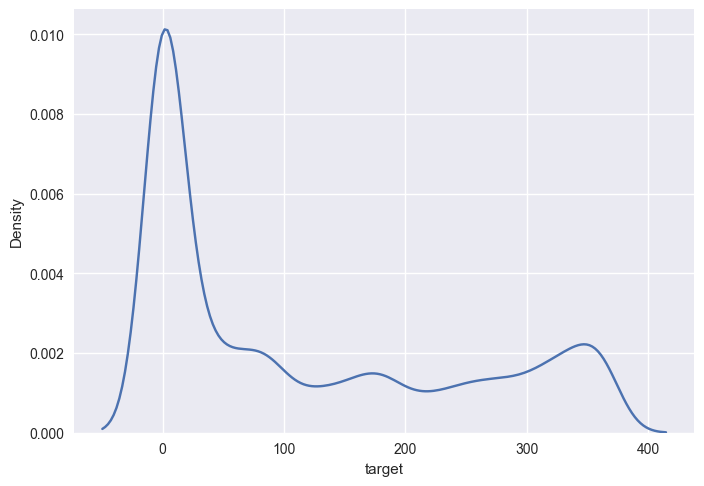

In [172]:
plot1 = sns.kdeplot(df['target'])

In [173]:
X = df.drop(columns='target')
y = df['target']

In [174]:
df['target'] = np.log10(df['target'])

c:\Users\Smart\PycharmProjects\Data_analysis\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


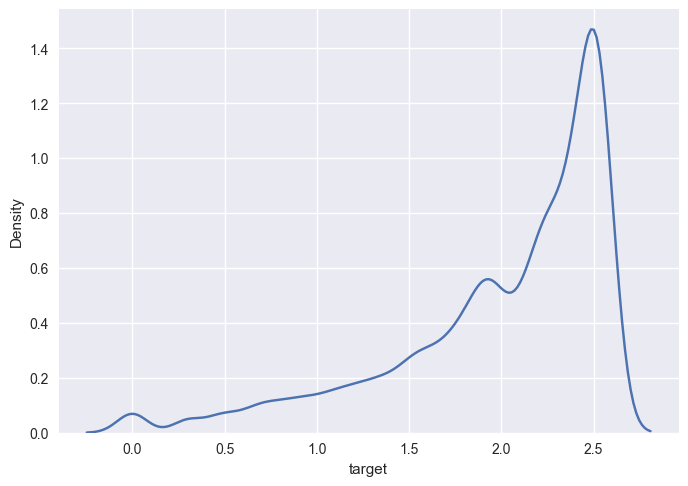

In [175]:
plot1 = sns.kdeplot(df['target'])

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29155 entries, 0 to 36670
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_name               29155 non-null  object 
 1   location_cluster        29155 non-null  object 
 2   location                29155 non-null  object 
 3   lat                     29155 non-null  float64
 4   lon                     29155 non-null  float64
 5   type_house              29155 non-null  object 
 6   sum                     29155 non-null  int64  
 7   min_days                29155 non-null  int64  
 8   amt_reviews             29155 non-null  int64  
 9   avg_reviews             29155 non-null  float64
 10  total_host              29155 non-null  int64  
 11  target                  29155 non-null  float64
 12  last_dt_year            29155 non-null  float64
 13  last_dt_month           29155 non-null  float64
 14  last_dt_day             29155 non-null  flo

In [177]:
df

,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,avg_reviews,total_host,target,last_dt_year,last_dt_month,last_dt_day,last_dt_dayofweek,last_dt_quarter,days_since_last_review,is_recent_review
0,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2.88,1,2.523746,2019.0,7.0,7.0,6.0,3.0,2281.0,0
1,Howard T.,Brooklyn,Clinton Hill,40.69172,-73.96934,Shared room,40,5,8,0.13,1,-inf,2015.0,2.0,25.0,2.0,1.0,3874.0,0
3,Federico,Manhattan,Harlem,40.81530,-73.95080,Private room,65,2,18,0.64,1,-inf,2018.0,11.0,4.0,6.0,4.0,2526.0,0
4,Lisa,Brooklyn,Bushwick,40.70230,-73.92935,Private room,99,2,26,0.76,1,2.190332,2019.0,6.0,23.0,6.0,2.0,2295.0,0
5,Rachel,Brooklyn,Midwood,40.62258,-73.97398,Entire home/apt,139,2,41,3.70,1,1.792392,2019.0,7.0,7.0,6.0,3.0,2281.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36665,Jermaine,Manhattan,East Village,40.72328,-73.98430,Private room,80,3,2,0.14,1,-inf,2018.0,5.0,18.0,4.0,2.0,2696.0,0
36666,Gabrielle,Manhattan,Harlem,40.81264,-73.94231,Private room,60,1,3,0.46,1,-inf,2019.0,1.0,1.0,1.0,1.0,2468.0,0
36667,Patti,Brooklyn,Boerum Hill,40.68554,-73.98471,Entire home/apt,265,2,10,0.18,1,-inf,2016.0,9.0,7.0,2.0,3.0,3314.0,0
36669,Tom,Brooklyn,South Slope,40.66617,-73.98862,Private room,90,2,15,2.34,1,1.959041,2019.0,6.0,18.0,1.0,2.0,2300.0,0


In [178]:
cat_columns = X.select_dtypes('object').columns
catboost_encoders = {}  # СОЗДАЕМ СЛОВАРЬ для хранения энкодеров

for col in cat_columns:
    encoder = CatBoostEncoder()  # создаем новый энкодер для каждой колонки
    X[col] = encoder.fit_transform(X[col], y)
    catboost_encoders[col] = encoder  # сохраняем в словарь

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [180]:
print(X_train, y_train)

        host_name  location_cluster    location       lat       lon  \
10587   88.821885        108.346102  106.039380  40.77290 -73.95761   
12690  114.656560        146.417635  137.582828  40.72942 -73.86551   
23887  106.372775        151.756228  128.316213  40.72000 -73.85411   
27634   66.328280        106.352206  104.984090  40.64008 -73.96579   
4328    64.164140        105.874396  103.010353  40.68502 -73.90883   
...           ...               ...         ...       ...       ...   
31601   95.828280        106.156749   79.793507  40.70740 -73.94063   
24241  114.656560        107.104871  123.235686  40.68897 -73.95477   
7007    19.109427        108.858106  147.888047  40.59887 -73.95790   
19474   37.092031        107.612599  123.203591  40.69384 -73.94220   
21152   58.328280        150.620189  129.940779  40.73998 -73.92619   

       type_house  sum  min_days  amt_reviews  avg_reviews  total_host  \
10587  118.751849  120         1            2         0.31           1   

# Подбор гиперпараметров

In [33]:
def objective_catboost(params):
    params = {
        'iterations': int(params['iterations']),
        'learning_rate': float(params['learning_rate']),
        'depth': int(params['depth']),
        'random_strength': float(params['random_strength']),
        'bagging_temperature': float(params['bagging_temperature']),
        'l2_leaf_reg': float(params['l2_leaf_reg']),
        'leaf_estimation_iterations': float(params['leaf_estimation_iterations']),
    }    

    model = CatBoostRegressor(**params, verbose=False, random_seed=42)
    score = cross_val_score(model, X_train, y_train, cv=3, verbose=0, scoring='neg_mean_squared_error')
    loss = -score.mean()

    return {'loss': loss, 'status': STATUS_OK, 'params': params}



space_cat_boost = {
    'iterations': hp.choice('iterations', range(100, 1000)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.00005), np.log(0.1)),
    'depth': hp.quniform('depth', 2, 15, 1),
    'random_strength': hp.uniform('random_strength', 0.5, 3),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1), np.log(15)),
    'leaf_estimation_iterations': hp.choice('leaf_estimation_iterations', [1, 5, 10, 20]),
}    

trial = Trials()

best_catboost = fmin(
    fn = objective_catboost,
    space=space_cat_boost,
    algo = tpe.suggest,
    verbose=1, 
    show_progressbar=True,
    max_evals=3
)


100%|██████████| 3/3 [40:36<00:00, 812.23s/trial, best loss: 10887.01855589463] 


In [19]:
def objective_LGBM(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': float(params['learning_rate']),
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'min_child_samples': int(params['min_child_samples']),
        'subsample': float(params['subsample']),
        'colsample_bytree': float(params['colsample_bytree']),
        'reg_alpha': float(params['reg_alpha']),
        'reg_lambda': float(params['reg_lambda']),
        'random_state': 42,
        'n_jobs': -1,
    }

    model = LGBMRegressor(**params, verbose = -1)

    score = cross_val_score(model, X_train, y_train, cv=5, 
                        scoring='neg_mean_squared_error', n_jobs=1, verbose=0)
    loss = -score.mean()


    return {'loss': loss, 'params': params, 'status': STATUS_OK}


LGBM_space = {
    'n_estimators': hp.uniform('n_estimators', 100, 2000),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.00005), np.log(0.1)),
    
    # Параметры дерева
    'num_leaves': hp.uniform('num_leaves', 10, 180),
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9, 11, -1]),  # -1 = no limit
    'min_child_samples': hp.choice('min_child_samples', [5, 10, 20, 30, 50]),
    
    # Регуляризация
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-3), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-3), np.log(10)),
    
    # Сэмплирование
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}

trials = Trials()

best_lgbm = fmin(
    fn=objective_LGBM,
    space=LGBM_space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=50,  # Увеличил для лучшего результата
    verbose=1,
    show_progressbar=True,
    rstate=np.random.default_rng(42)
)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [22:02<00:00, 26.44s/trial, best loss: 10254.545733864124]


In [29]:
def objective_RF(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']) if params['max_depth'] != -1 else None,
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': float(params['max_features']),
        'criterion': params['criterion'],
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params, verbose=0)

    score = cross_val_score(model, X_train, y_train, cv=3, verbose=0, 
                            scoring='neg_mean_squared_error', n_jobs=1)
    loss = -score.mean()

    return {'loss': loss, 'params': params, 'status': STATUS_OK}

RF_space = {
    'n_estimators': hp.uniform('n_estimators', 100, 1000),
    'max_depth': hp.choice('max_depth', [10, 15, 20, 25, -1]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4]),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'criterion': hp.choice('criterion', ['squared_error', 'absolute_error', 'friedman_mse'])
}

trial = Trials()

best_rf = fmin(
    fn = objective_RF, 
    space=RF_space,
    algo=tpe.suggest,
    max_evals=3, 
    verbose=1,
    show_progressbar=True
)


  0%|          | 0/3 [01:29<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [31]:
def objective_XGB(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': float(params['learning_rate']),
        'max_depth': int(params['max_depth']),
        'min_child_weight': float(params['min_child_weight']),
        'subsample': float(params['subsample']),
        'colsample_bytree': float(params['colsample_bytree']),
        'reg_alpha': float(params['reg_alpha']),
        'reg_lambda': float(params['reg_lambda']),
        'gamma': float(params['gamma']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBRegressor(**params, verbosity = 0)

    score = cross_val_score(model, X_train, y_train, cv=5, verbose=0,
                            scoring='neg_mean_squared_error', n_jobs=1)
    loss = -score.mean()


    return {'loss': loss, 'params': params, 'status': STATUS_OK}


XGB_space = {
    'n_estimators': hp.uniform('n_estimators', 100, 2000),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0005), np.log(0.1)),
    
    # Параметры дерева
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7, 8, 9, 10]),
    'min_child_weight': hp.choice('min_child_weight', [1, 2, 3, 4, 5, 6, 7, 8]),
    'gamma': hp.uniform('gamma', 0, 5),
    
    # Регуляризация
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-5), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-5), np.log(10)),
    
    # Сэмплирование
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}

trials_XGB = Trials()

best_xgb = fmin(
    fn=objective_XGB,
    space=XGB_space,
    algo=tpe.suggest,
    trials=trials_XGB,
    max_evals=50,
    verbose=1,
    show_progressbar=True,
    rstate=np.random.default_rng(42)
)


100%|██████████| 50/50 [33:09<00:00, 39.79s/trial, best loss: 10216.2283203125]


# Стекинг моделей

In [ ]:
# Преобразуем лучшие параметры из формата Hyperopt в нормальный формат
best_catboost_params = space_eval(space_cat_boost, best_catboost)
best_lgbm_params = space_eval(LGBM_space, best_lgbm)
best_rf_params = space_eval(RF_space, best_rf)
best_xgb_params = space_eval(XGB_space, best_xgb)

# Функция для преобразования типов параметров
def fix_parameter_types(params, model_type):
    fixed_params = params.copy()
    
    if model_type == 'catboost':
        fixed_params['iterations'] = int(fixed_params['iterations'])
        fixed_params['depth'] = int(fixed_params['depth'])
        if 'leaf_estimation_iterations' in fixed_params:
            fixed_params['leaf_estimation_iterations'] = int(fixed_params['leaf_estimation_iterations'])
    
    elif model_type == 'lightgbm':
        fixed_params['n_estimators'] = int(fixed_params['n_estimators'])
        fixed_params['num_leaves'] = int(fixed_params['num_leaves'])
        fixed_params['max_depth'] = int(fixed_params['max_depth']) if fixed_params['max_depth'] != -1 else -1
        fixed_params['min_child_samples'] = int(fixed_params['min_child_samples'])
    
    elif model_type == 'randomforest':
        fixed_params['n_estimators'] = int(fixed_params['n_estimators'])
        fixed_params['max_depth'] = int(fixed_params['max_depth']) if fixed_params['max_depth'] != -1 else None
        fixed_params['min_samples_split'] = int(fixed_params['min_samples_split'])
        fixed_params['min_samples_leaf'] = int(fixed_params['min_samples_leaf'])
    
    elif model_type == 'xgboost':
        fixed_params['n_estimators'] = int(fixed_params['n_estimators'])
        fixed_params['max_depth'] = int(fixed_params['max_depth'])
    
    return fixed_params

# ПРЕОБРАЗУЕМ параметры в правильные типы
best_catboost_params_fixed = fix_parameter_types(best_catboost_params, 'catboost')
best_lgbm_params_fixed = fix_parameter_types(best_lgbm_params, 'lightgbm')
best_rf_params_fixed = fix_parameter_types(best_rf_params, 'randomforest')
best_xgb_params_fixed = fix_parameter_types(best_xgb_params, 'xgboost')

print("🔧 ПРОВЕРКА ПАРАМЕТРОВ:")
print(f"CatBoost: {best_catboost_params_fixed}")
print(f"LightGBM: {best_lgbm_params_fixed}")
print(f"RandomForest: {best_rf_params_fixed}")
print(f"XGBoost: {best_xgb_params_fixed}")

# Создаем модели с ИСПРАВЛЕННЫМИ параметрами
model_1 = CatBoostRegressor(**best_catboost_params_fixed, verbose=0)
model_2 = LGBMRegressor(**best_lgbm_params_fixed, verbose=-1)
model_3 = RandomForestRegressor(**best_rf_params_fixed, verbose=0)
model_4 = XGBRegressor(**best_xgb_params_fixed, verbose=0)

models = [model_1, model_2, model_3, model_4]


# Сохраняем каждую модель отдельно
for i, model in enumerate(models):
    with open(f'model_{i+1}.pkl', 'wb') as f:
        pickle.dump(model, f)

print("✅ Все модели сохранены в отдельных файлах")


🔧 ПРОВЕРКА ПАРАМЕТРОВ:
CatBoost: {'bagging_temperature': 0.7693328418282213, 'depth': 10, 'iterations': 833, 'l2_leaf_reg': 2.644872282528268, 'leaf_estimation_iterations': 20, 'learning_rate': 0.0036437708925194496, 'random_strength': 2.775505385695524}
LightGBM: {'colsample_bytree': 0.7207293163181685, 'learning_rate': 0.010704375504982596, 'max_depth': 11, 'min_child_samples': 10, 'n_estimators': 897, 'num_leaves': 117, 'reg_alpha': 0.04310616334361142, 'reg_lambda': 0.3205857953902766, 'subsample': 0.6031440910620923}
RandomForest: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 0.8225647051698298, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 792}
XGBoost: {'colsample_bytree': 0.6941429978531766, 'gamma': 1.4947397376924076, 'learning_rate': 0.004723329762049837, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 1236, 'reg_alpha': 0.4977015198513638, 'reg_lambda': 0.0017152265904805506, 'subsample': 0.6483577718109695}
NGBoost: {'col_sample

Обучение CatBoostRegressor...
✅ CatBoostRegressor MSE: 10821.0155



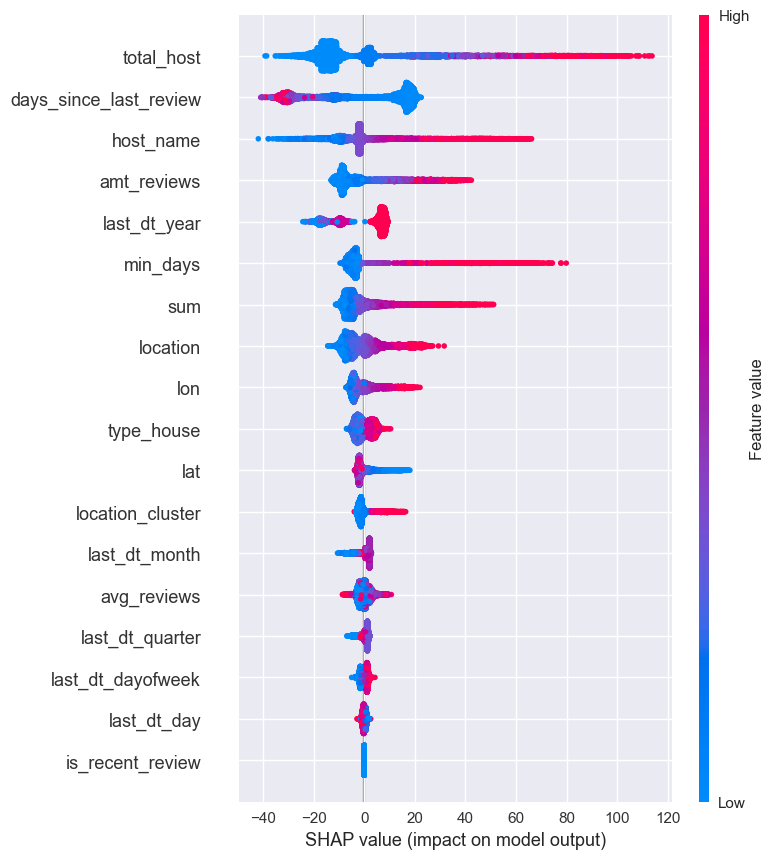

Обучение LGBMRegressor...
✅ LGBMRegressor MSE: 10154.0173



KeyboardInterrupt: 

In [158]:
for model in models:
    model_name = model.__class__.__name__

    print(f"Обучение {model_name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    print(f"✅ {model_name} MSE: {mse:.4f}\n")

    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_test)

    shap.summary_plot(shap_vals, X_test)

🔍 АНАЛИЗ ОСТАТКОВ МОДЕЛЕЙ:
CatBoostRegressor: MSE = 10821.0155
LGBMRegressor: MSE = 10154.0173
RandomForestRegressor: MSE = 10389.8673
XGBRegressor: MSE = 10081.5605
NGBRegressor: MSE = 16916.2722


C:\Users\Smart\AppData\Local\Temp\ipykernel_17212\3381319999.py:83: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Smart\PycharmProjects\Data_analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


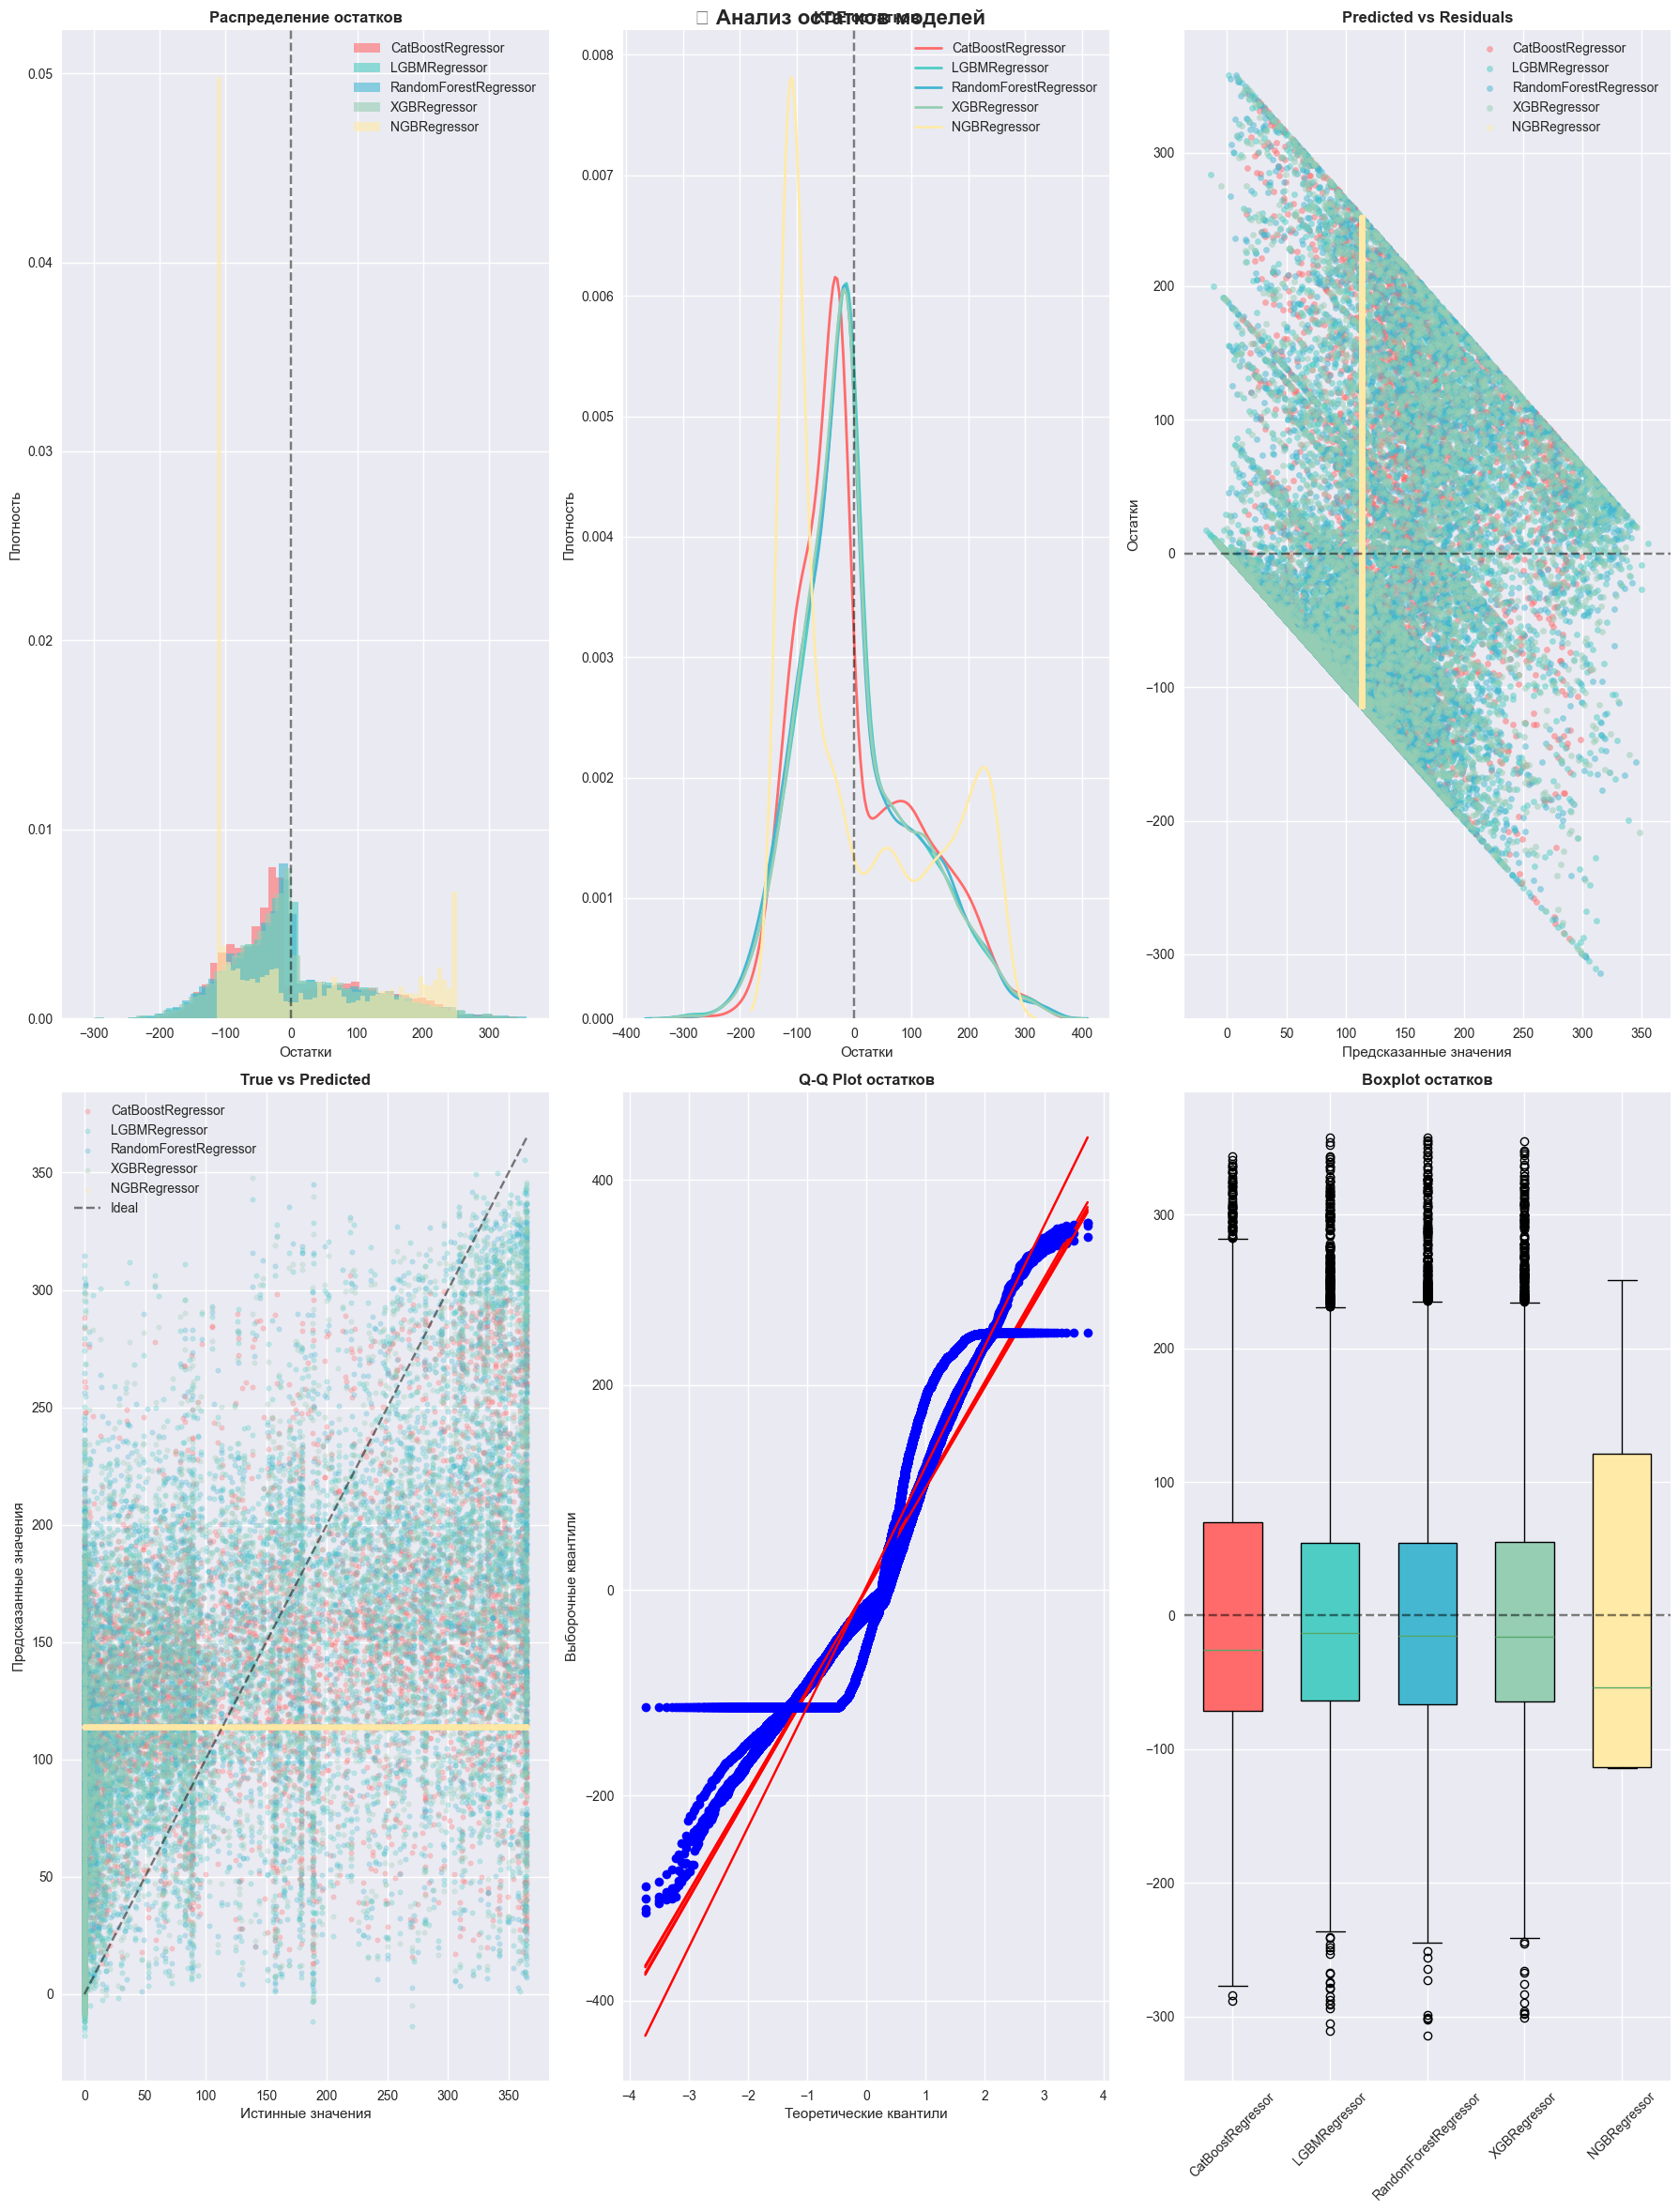

In [110]:
# Настройка стиля
plt.style.use('seaborn-v0_8')
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# Создаем большую фигуру
fig, axes = plt.subplots(2, 3, figsize=(18, 24))
fig.suptitle('📊 Анализ остатков моделей', fontsize=16, fontweight='bold')

print("🔍 АНАЛИЗ ОСТАТКОВ МОДЕЛЕЙ:")
print("=" * 50)

for i, (model, color) in enumerate(zip(models, colors)):
    model_name = model.__class__.__name__
    
    # Получаем предсказания
    if hasattr(model, 'pred_dist'):
        y_pred_dist = model.pred_dist(X_test)
        y_pred = y_pred_dist.params.get('loc', y_pred_dist.params.get('scale', 0))
    else:
        y_pred = model.predict(X_test)
    
    # Считаем остатки
    residuals = y_test - y_pred
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"{model_name}: MSE = {mse:.4f}")
    
    # 1. Распределение остатков
    axes[0, 0].hist(residuals, bins=50, alpha=0.6, color=color, label=model_name, density=True)
    
    # 2. KDE остатков
    sns.kdeplot(residuals, ax=axes[0, 1], color=color, label=model_name, linewidth=2)
    
    # 3. Predicted vs Residuals
    axes[0, 2].scatter(y_pred, residuals, alpha=0.5, color=color, label=model_name, s=20)
    
    # 4. True vs Predicted
    axes[1, 0].scatter(y_test, y_pred, alpha=0.3, color=color, label=model_name, s=15)
    
    # 5. QQ-plot для нормальности остатков
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    
    # 6. Boxplot остатков
    box_data = axes[1, 2].boxplot([residuals], positions=[i], patch_artist=True, widths=0.6)
    box_data['boxes'][0].set_facecolor(color)

# Настройка графиков
axes[0, 0].set_title('Распределение остатков', fontweight='bold')
axes[0, 0].set_xlabel('Остатки')
axes[0, 0].set_ylabel('Плотность')
axes[0, 0].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].legend()

axes[0, 1].set_title('KDE остатков', fontweight='bold')
axes[0, 1].set_xlabel('Остатки')
axes[0, 1].set_ylabel('Плотность')
axes[0, 1].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].legend()

axes[0, 2].set_title('Predicted vs Residuals', fontweight='bold')
axes[0, 2].set_xlabel('Предсказанные значения')
axes[0, 2].set_ylabel('Остатки')
axes[0, 2].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0, 2].legend()

axes[1, 0].set_title('True vs Predicted', fontweight='bold')
axes[1, 0].set_xlabel('Истинные значения')
axes[1, 0].set_ylabel('Предсказанные значения')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'k--', alpha=0.5, label='Ideal')
axes[1, 0].legend()

axes[1, 1].set_title('Q-Q Plot остатков', fontweight='bold')
axes[1, 1].set_xlabel('Теоретические квантили')
axes[1, 1].set_ylabel('Выборочные квантили')

axes[1, 2].set_title('Boxplot остатков', fontweight='bold')
axes[1, 2].set_xticks(range(len(models)))
axes[1, 2].set_xticklabels([model.__class__.__name__ for model in models], rotation=45)
axes[1, 2].axhline(0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
model_final = StackingRegressor(
    estimators= [('cat', model_1), 
                ('lgb', model_2),
                ('rf', model_3),
                ('xgb', model_4),
                    ],
    verbose = 1,
    cv = 5, 
    n_jobs = -1, 
    final_estimator=LinearRegression())

model_final.fit(X_train, y_train)

pred = model_final.predict(X_test)


print(f'MSE стекинга {mean_squared_error(pred, y_test)}')

MSE стекинга 10084.369836738893


# Интерпретация модели

In [152]:
base_predictions = []
for model in model_final.estimators_:
    pred = model.predict(X_test)
    base_predictions.append(pred)


base_predictions = pd.DataFrame(np.array(base_predictions).T, columns=['Catboost', 'LGBM', 'RandomForest', 'XGBoost'])
display(base_predictions)



,Catboost,LGBM,RandomForest,XGBoost
0,40.408187,8.595042,9.302909,14.284071
1,128.689852,127.576567,111.065850,137.455505
2,121.626230,121.199039,114.720116,119.810806
3,20.988217,39.248764,22.248247,21.424973
4,128.462106,167.166915,147.161878,128.604752
...,...,...,...,...
7284,154.339831,134.561356,147.521007,151.863846
7285,46.884731,44.276239,61.563699,49.565807
7286,132.657084,182.436851,164.957082,186.187363
7287,168.752968,153.230051,164.802286,159.609940


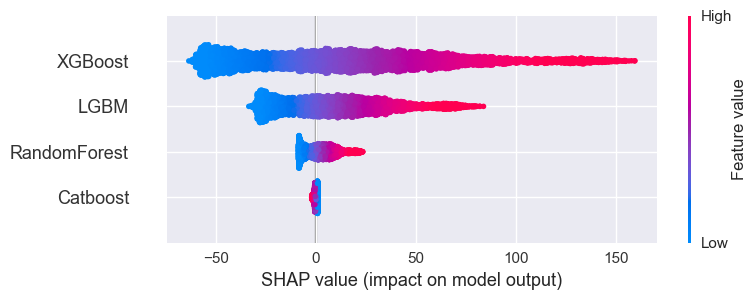

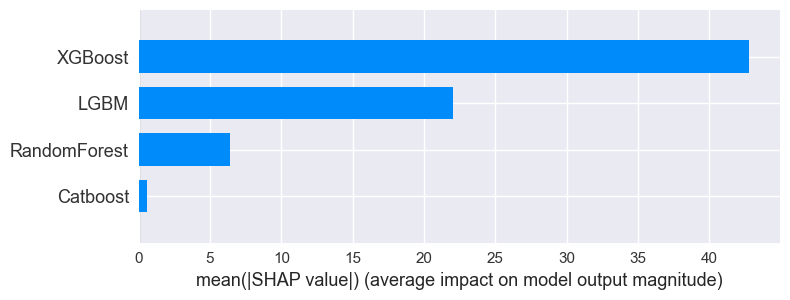

In [211]:
explainer = shap.LinearExplainer(model_final.final_estimator_, base_predictions)
shap_values = explainer.shap_values(base_predictions)


shap.summary_plot(shap_values, base_predictions)
shap.summary_plot(shap_values, base_predictions, plot_type = 'bar')

# Делаем сабмит

In [206]:
test_df = pd.read_csv('test.csv')
test_df



,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host
0,Amazing 4 Bedrooms 4 Bathrooms sleeps 9,199147185,Lou,Brooklyn,Sunset Park,40.66468,-73.99785,Entire home/apt,399,1,0,NaN,NaN,5
1,Super Spacious room in Brooklyn,259427246,Nelly,Brooklyn,Bedford-Stuyvesant,40.67880,-73.92722,Private room,43,1,4,2019-06-10,2.00,3
2,Stunning 1-Bedroom NYC Apartment on the River!,30283594,Kara,Manhattan,Hell's Kitchen,40.76170,-73.99762,Entire home/apt,275,30,2,2017-09-17,0.08,121
3,Large Bushwick Bedroom in Newly Renovated Aprt...,51985960,Jonathan,Brooklyn,Williamsburg,40.70748,-73.92835,Private room,40,3,0,NaN,NaN,2
4,Bedroom in Crown Heights,68039772,Celeste,Brooklyn,Crown Heights,40.67249,-73.95564,Private room,55,4,1,2018-12-02,0.14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12219,Comfortable stay,15344412,Abe,Staten Island,New Springville,40.58091,-74.15485,Private room,52,1,74,2019-06-25,3.34,3
12220,"Spacious 1 bedroom in Flatbush, Brooklyn, NY.",107090465,Linwood,Brooklyn,East Flatbush,40.63835,-73.94621,Entire home/apt,125,3,2,2019-05-10,0.61,1
12221,Gramercy~Reno New 1BR-Sleeps 4~,2119276,Host,Manhattan,Gramercy,40.73568,-73.98062,Entire home/apt,150,30,2,2015-08-07,0.03,39
12222,Bright room in 2BR apt in Nolita!,24170584,Lauren,Manhattan,Little Italy,40.71959,-73.99604,Private room,99,2,2,2015-10-06,0.04,2


In [207]:
test_df['last_dt'] = pd.to_datetime(test_df['last_dt'])
test_df['last_dt_year'] = test_df['last_dt'].dt.year
test_df['last_dt_month'] = test_df['last_dt'].dt.month
test_df['last_dt_day'] = test_df['last_dt'].dt.day
test_df['last_dt_dayofweek'] = test_df['last_dt'].dt.dayofweek
test_df['last_dt_quarter'] = test_df['last_dt'].dt.quarter

# ИСПОЛЬЗУЕМ ТОТ ЖЕ current_time!
current_time = pd.Timestamp.now()  # лучше сохранить одну дату
test_df['days_since_last_review'] = (current_time - test_df['last_dt']).dt.days
test_df['is_recent_review'] = (test_df['days_since_last_review'] < 30).astype(int)

test_df = test_df.drop(columns=['name', '_id', 'last_dt'])

# КАТЕГОРИАЛЬНЫЕ ФИЧИ - ИСПОЛЬЗУЕМ СОХРАНЕННЫЕ ЭНКОДЕРЫ!
for col in cat_columns:
    if col in test_df.columns and col in catboost_encoders:  # теперь проверяем в catboost_encoders
        test_df[col] = catboost_encoders[col].transform(test_df[col])
    else:
        # Если в test нет какой-то колонки, создаем с нулями
        test_df[col] = 0

In [210]:
predictions = model_final.predict(test_df)
df_answer = pd.DataFrame({
    'index': np.arange(len(predictions)),
    'prediction': predictions
})
df_answer.to_csv('sample_submission.csv', index=False)